# Exploring Data

## Imports

In [2]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

## How many different cases are there, by department?

In [3]:
df.groupby('department').count().sort(desc('count')).show(truncate = False)

+------------------------+------+
|department              |count |
+------------------------+------+
|DSD/Code Enforcement    |321374|
|Solid Waste             |279270|
|Animal Care Services    |116915|
|Trans & Cap Improvements|96193 |
|Parks & Recreation      |19907 |
|Metro Health            |5163  |
|Customer Service        |2849  |
|City Council            |33    |
+------------------------+------+



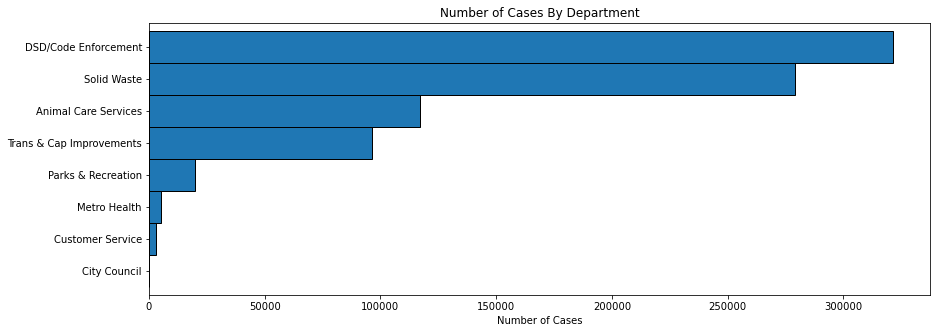

In [7]:
# First aggregate with spark
graph = (
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=True)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

title = plt.title("Number of Cases By Department")
ylabel = plt.ylabel("")
xlabel = plt.xlabel("Number of Cases")

## Does the percentage of cases that are late vary by department?

In [112]:
(
df
    .where(col('case_late') == True)
    .groupby('department')
    .count()
    .show()
)

+--------------------+-----+
|          department|count|
+--------------------+-----+
|         Solid Waste|32945|
|Animal Care Services|23276|
|Trans & Cap Impro...| 5411|
|  Parks & Recreation| 3797|
|    Customer Service| 2010|
|        Metro Health|  829|
|DSD/Code Enforcement|26235|
+--------------------+-----+



In [113]:
late_cases = (
df
    .where(col('case_late') == True)
    .groupby('department')
    .count()
     .withColumnRenamed("count", "late")


) 

In [114]:
total_cases = (

df
    .groupby('department')
    .count()
    .withColumnRenamed("count", "total")
    .withColumnRenamed('department', 'department1')
)

In [115]:
late_and_total_cases = late_cases.join(total_cases, late_cases['department'] == total_cases['department1'], "left")

In [116]:
late_and_total_cases.show()

+--------------------+-----+--------------------+------+
|          department| late|         department1| total|
+--------------------+-----+--------------------+------+
|         Solid Waste|32945|         Solid Waste|279270|
|Animal Care Services|23276|Animal Care Services|116915|
|Trans & Cap Impro...| 5411|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 3797|  Parks & Recreation| 19907|
|    Customer Service| 2010|    Customer Service|  2849|
|        Metro Health|  829|        Metro Health|  5163|
|DSD/Code Enforcement|26235|DSD/Code Enforcement|321374|
+--------------------+-----+--------------------+------+



In [117]:
late_and_total_cases = late_and_total_cases.withColumn('percent_late', col('late') / col('total'))

In [118]:
late_and_total_cases.show()

+--------------------+-----+--------------------+------+-------------------+
|          department| late|         department1| total|       percent_late|
+--------------------+-----+--------------------+------+-------------------+
|         Solid Waste|32945|         Solid Waste|279270| 0.1179682744297633|
|Animal Care Services|23276|Animal Care Services|116915|0.19908480520035923|
|Trans & Cap Impro...| 5411|Trans & Cap Impro...| 96193|0.05625149439148379|
|  Parks & Recreation| 3797|  Parks & Recreation| 19907|0.19073692670919776|
|    Customer Service| 2010|    Customer Service|  2849| 0.7055107055107055|
|        Metro Health|  829|        Metro Health|  5163|0.16056556265736974|
|DSD/Code Enforcement|26235|DSD/Code Enforcement|321374| 0.0816338596152769|
+--------------------+-----+--------------------+------+-------------------+



In [119]:
late_and_total_cases = late_and_total_cases.drop("late", "department1", 'total')

In [120]:
late_and_total_cases.show(truncate = False)

+------------------------+-------------------+
|department              |percent_late       |
+------------------------+-------------------+
|Solid Waste             |0.1179682744297633 |
|Animal Care Services    |0.19908480520035923|
|Trans & Cap Improvements|0.05625149439148379|
|Parks & Recreation      |0.19073692670919776|
|Customer Service        |0.7055107055107055 |
|Metro Health            |0.16056556265736974|
|DSD/Code Enforcement    |0.0816338596152769 |
+------------------------+-------------------+



In [121]:
late_and_total_cases = late_and_total_cases.withColumn("percent_late", round(col("percent_late") *100, 2))

In [122]:
late_and_total_cases.show()

+--------------------+------------+
|          department|percent_late|
+--------------------+------------+
|         Solid Waste|        11.8|
|Animal Care Services|       19.91|
|Trans & Cap Impro...|        5.63|
|  Parks & Recreation|       19.07|
|    Customer Service|       70.55|
|        Metro Health|       16.06|
|DSD/Code Enforcement|        8.16|
+--------------------+------------+



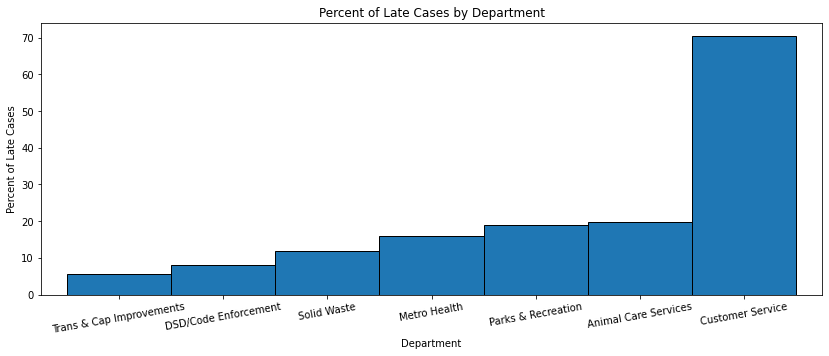

In [133]:
graph = (
    late_and_total_cases
    # then pass to pandas
    .toPandas()
    .set_index("department")["percent_late"]
    .sort_values(ascending=True)
    .plot.bar(width=1, edgecolor="black", figsize=(14, 5))
)
title = plt.title("Percent of Late Cases by Department")
ylabel = plt.ylabel("Percent of Late Cases")
xlabel = plt.xlabel("Department")
ticks = plt.xticks(rotation = 10) 

## On average, how late are the late cases by department?

In [153]:
mean_days_late = (
    df 
    .groupby("department")
    .agg(avg('num_days_late').alias('average_days_late'))
)

In [154]:
mean_days_late.show()

+--------------------+-------------------+
|          department|  average_days_late|
+--------------------+-------------------+
|         Solid Waste|  -2.19386442402253|
|Animal Care Services|-226.16549770717424|
|Trans & Cap Impro...|-20.509793501785392|
|  Parks & Recreation| -5.283345998745916|
|    Customer Service|  59.49019459221517|
|        Metro Health| -4.904223205386015|
|        City Council|               null|
|DSD/Code Enforcement|  -38.3234677253743|
+--------------------+-------------------+



In [155]:
df.where(col('department') == "City Council").filter('num_days_late is not null').count()

0

All of the number of days late values for city council are null. 

In [156]:
mean_days_late = mean_days_late.where(col('department') != "City Council")

In [157]:
mean_days_late.show()

+--------------------+-------------------+
|          department|  average_days_late|
+--------------------+-------------------+
|         Solid Waste|  -2.19386442402253|
|Animal Care Services|-226.16549770717424|
|Trans & Cap Impro...|-20.509793501785392|
|  Parks & Recreation| -5.283345998745916|
|    Customer Service|  59.49019459221517|
|        Metro Health| -4.904223205386015|
|DSD/Code Enforcement|  -38.3234677253743|
+--------------------+-------------------+



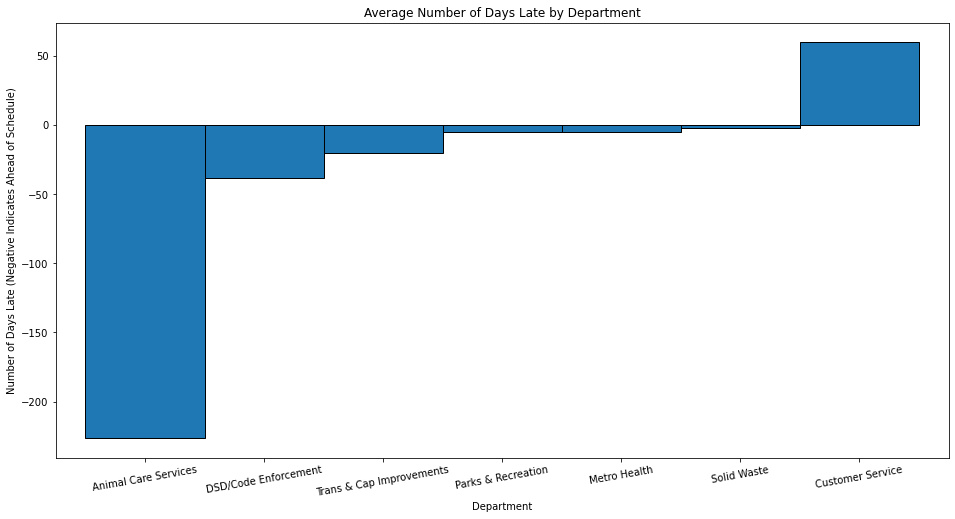

In [164]:
graph = (
    mean_days_late
    # then pass to pandas
    .toPandas()
    .set_index("department")["average_days_late"]
    .sort_values(ascending=True)
    .plot.bar(width=1, edgecolor="black", figsize=(16, 8))
)
title = plt.title("Average Number of Days Late by Department")
ylabel = plt.ylabel("Number of Days Late (Negative Indicates Ahead of Schedule)")
xlabel = plt.xlabel("Department")
ticks = plt.xticks(rotation = 10) 

## What is the service type that is the most late? Just for Parks & Rec?

In [182]:
mean_days_late_by_service = (
df
    .groupby("service_request_type")
    .agg(avg('num_days_late').alias('number_days_late'))
    .sort(desc('number_days_late'))
)

In [183]:
mean_days_late_by_service.show(truncate = False)

+--------------------------------------+------------------+
|service_request_type                  |number_days_late  |
+--------------------------------------+------------------+
|Zoning: Junk Yards                    |175.95636210420946|
|Labeling for Used Mattress            |162.43032902285717|
|Record Keeping of Used Mattresses     |153.99724039428568|
|Signage Requied for Sale of Used Mattr|151.63868055333333|
|Storage of Used Mattress              |142.11255641500003|
|Zoning: Recycle Yard                  |135.928516124798  |
|Donation Container Enforcement        |131.75610506358706|
|License Requied Used Mattress Sales   |128.79828704142858|
|Traffic Signal Graffiti               |77.90021217000002 |
|Complaint                             |72.51790932659715 |
|Vendors                               |66.11831254322685 |
|Reservation Assistance                |66.03116319       |
|Curbstoning                           |60.60433857798666 |
|No Address Posted                     |

Zoning: Junk Yards has the highest average number of days late.

In [184]:
total_late_by_service = (
df
    .where(col('case_late') == True)
    .groupby("service_request_type")
    .count()
    .withColumnRenamed('count', 'number_late_cases')
    .sort(desc(col('number_late_cases')))
)

In [185]:
total_late_by_service.show(truncate = False)

+----------------------------------------+-----------------+
|service_request_type                    |number_late_cases|
+----------------------------------------+-----------------+
|Trapped/Confined Animal                 |5696             |
|No Pickup                               |5498             |
|Aggressive Animal(Non-Critical)         |5195             |
|Animal Neglect                          |4568             |
|Solid Waste Fees and Charges            |4444             |
|Damaged Cart                            |4173             |
|Aggressive Animal(Critical)             |4124             |
|Front Or Side Yard Parking              |3952             |
|Bandit Signs                            |3779             |
|Cart Exchange Request                   |3447             |
|Right Of Way/Sidewalk Obstruction       |2682             |
|Overgrown Yard/Trash                    |2467             |
|Lost/Stolen Cart                        |2437             |
|Cart Delivery          

Trapped/Confined Animal has the highest number of late cases.

In [187]:
parks_and_rec = (
df
    .where(col('department') == "Parks & Recreation")
)

In [188]:
mean_days_late_by_service_parks = (
parks_and_rec
    .groupby("service_request_type")
    .agg(avg('num_days_late').alias('number_days_late'))
    .sort(desc('number_days_late'))
)

In [190]:
mean_days_late_by_service_parks.show(truncate = False)

+----------------------------+--------------------+
|service_request_type        |number_days_late    |
+----------------------------+--------------------+
|Reservation Assistance      |66.03116319         |
|Park Building Maint Invest  |24.32232084089583   |
|Sportfield Lighting         |19.37709106260071   |
|Electrical                  |11.750504897402122  |
|Amenity Park Improvement    |10.11497437191964   |
|Tree Removal                |5.658236274288591   |
|Painting                    |4.354412358281138   |
|Tree Trimming/Maintenance   |4.241499056964815   |
|General Building Maintenance|4.191945529579545   |
|Masonry                     |4.1756982508859055  |
|Sign Maintenance            |4.141523684634148   |
|Fence/Gate Repair           |3.864462383908332   |
|Miscellaneous Park Equipment|2.4600516038089166  |
|Trail/Greenway Maintenance  |1.691468919487805   |
|Carpentry                   |0.5074417902093621  |
|Fencing                     |-0.1701231483028569 |
|Graffiti   

In the Park and Recreation Department, Reservation Assistance has the highest average number of days late. 

In [192]:
total_late_by_service_parks = (
parks_and_rec
    .where(col('case_late') == True)
    .groupby("service_request_type")
    .count()
    .withColumnRenamed('count', 'number_late_cases')
    .sort(desc(col('number_late_cases')))
)

In [193]:
total_late_by_service_parks.show(truncate = False)

+-------------------------------------+-----------------+
|service_request_type                 |number_late_cases|
+-------------------------------------+-----------------+
|Carpentry                            |587              |
|Electrical                           |481              |
|Plumbing                             |325              |
|Graffiti                             |315              |
|Sportfield Lighting                  |268              |
|Graffiti Int                         |255              |
|Tree Trimming/Maintenance            |171              |
|Masonry                              |128              |
|General Building Maintenance         |105              |
|Painting                             |92               |
|Tree Removal                         |84               |
|Welding                              |81               |
|Plumbing/Drinking Fountain/Sprinklers|77               |
|Lake and Ponds Maintenance           |76               |
|Heating and A

Carpentry has the highest total number of late days.

## For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [218]:
departments = [
    'Solid Waste',
    'Animal Care Services',
    'Trans & Cap Services', 
    'Parks & Recreation', 
    'Customer Service',
    'Metro Health',
    'DSD/Code Enforcement'   
]

In [222]:
for dept in departments:
    print(dept)
    (
    df
    .where(col('department') == dept)
    .groupby('service_request_type')
    .count()
    .sort(desc(col('count')))
    .show(5, truncate = False)
    )

Solid Waste
+---------------------+-----+
|service_request_type |count|
+---------------------+-----+
|No Pickup            |86855|
|Damaged Cart         |30338|
|Cart Exchange Request|22024|
|Lost/Stolen Cart     |18731|
|Dead Animal - Dog    |16714|
+---------------------+-----+
only showing top 5 rows

Animal Care Services
+-------------------------------+-----+
|service_request_type           |count|
+-------------------------------+-----+
|Stray Animal                   |26760|
|Aggressive Animal(Non-Critical)|24882|
|Animal Neglect                 |13441|
|Trapped/Confined Animal        |11354|
|Public Nuisance(Own Animal)    |10715|
+-------------------------------+-----+
only showing top 5 rows

Trans & Cap Services
+--------------------+-----+
|service_request_type|count|
+--------------------+-----+
+--------------------+-----+

Parks & Recreation
+----------------------------+-----+
|service_request_type        |count|
+----------------------------+-----+
|Carpentry         

## Does whether or not its a weekend matter for when a case is opened/closed?

In [4]:
df.show(1, vertical = True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [22]:
df = df.withColumn("opened_on_weekend", dayofweek("case_opened_date").isin([1,7]).cast("boolean"))

In [23]:
df = df.withColumn("closed_on_weekend", dayofweek("case_closed_date").isin([1,7]).cast("boolean"))

In [24]:
df.show(1, vertical = True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 case_opened_day      | Mon       

In [25]:
(
    df
    .groupby('opened_on_weekend')
    .count()
    .show()
)

+-----------------+------+
|opened_on_weekend| count|
+-----------------+------+
|             true| 82443|
|            false|759261|
+-----------------+------+



In [26]:
(
    df
    .groupby('closed_on_weekend')
    .count()
    .show()
)

+-----------------+------+
|closed_on_weekend| count|
+-----------------+------+
|             true| 88027|
|            false|735567|
|             null| 18110|
+-----------------+------+



In [27]:
(
    df
    .groupby('opened_on_weekend', 'closed_on_weekend')
    .count()
    .show()
)

+-----------------+-----------------+------+
|opened_on_weekend|closed_on_weekend| count|
+-----------------+-----------------+------+
|             true|            false| 44714|
|             true|             true| 36674|
|            false|            false|690853|
|            false|             true| 51353|
|             true|             null|  1055|
|            false|             null| 17055|
+-----------------+-----------------+------+



The majority of cases are opened and closed on weekdays. 

## On average, how many cases are opened a day for the Customer Service department?

In [33]:
   to_date(col("input_timestamp"),"yyyy-MM-dd")

In [44]:
cases_per_day_customer_service = (
df
    .where(col('department') == 'Customer Service')
    .groupby(to_date(col('case_opened_date'), 'yyyy-MM-dd'))
    .count()
)

In [45]:
cases_per_day_customer_service.show()

+-------------------------------------+-----+
|to_date(case_opened_date, yyyy-MM-dd)|count|
+-------------------------------------+-----+
|                           2018-01-23|    9|
|                           2018-01-11|    8|
|                           2018-01-08|    1|
|                           2018-01-18|    8|
|                           2018-02-22|    1|
|                           2018-01-05|    8|
|                           2018-01-13|    2|
|                           2018-02-01|    9|
|                           2018-02-04|    1|
|                           2018-02-23|    9|
|                           2018-01-12|    5|
|                           2018-01-20|    2|
|                           2018-01-25|    5|
|                           2018-02-02|    4|
|                           2018-02-12|    4|
|                           2018-01-29|    5|
|                           2018-02-08|    2|
|                           2018-02-09|    5|
|                           2018-0

In [48]:
cases_per_day_customer_service.select(avg('count').alias('Average Customer Service Cases Per Day')).show()

+--------------------------------------+
|Average Customer Service Cases Per Day|
+--------------------------------------+
|                           5.564453125|
+--------------------------------------+



## Does the number of service requests for the solid waste department vary by day of the week?

In [50]:
df = df.withColumn('day_of_the_week_opened', date_format('case_opened_date', 'EEEE'))

In [51]:
df.show(1, vertical = True)

-RECORD 0--------------------------------------
 case_id                | 1014127332           
 case_opened_date       | 2018-01-01 00:42:00  
 case_closed_date       | 2018-01-01 12:29:00  
 case_due_date          | 2020-09-26 00:42:00  
 case_late              | false                
 num_days_late          | -998.5087616000001   
 case_closed            | true                 
 service_request_type   | Stray Animal         
 SLA_days               | 999.0                
 case_status            | Closed               
 source_id              | svcCRMLS             
 request_address        | 2315  EL PASO ST,... 
 council_district       | 005                  
 num_weeks_late         | -142.6441088         
 zipcode                | 78207                
 case_age               | 219                  
 days_to_closed         | 0                    
 case_lifetime          | 0                    
 department             | Animal Care Services 
 dept_subject_to_SLA    | true          

In [54]:
(
df
    .where(col('department') == "Solid Waste")
    .groupby(col('day_of_the_week_opened'))
    .count()
    .sort(desc('count'))
    .show()
)

+----------------------+-----+
|day_of_the_week_opened|count|
+----------------------+-----+
|               Tuesday|58120|
|                Monday|58085|
|                Friday|51203|
|              Thursday|47718|
|             Wednesday|41947|
|              Saturday|15312|
|                Sunday| 6885|
+----------------------+-----+



Yes! Tuesday received the most service requests overall, whereas Sunday received the least.

In [61]:
solid_waste_request_per_day = (
df
    .where(col('department') == "Solid Waste")
    .groupby(to_date(col('case_opened_date'), 'yyyy-MM-dd').alias('date'))
    .count()
    .sort(desc('count'))
)

In [62]:
solid_waste_request_per_day.show()

+----------+-----+
|      date|count|
+----------+-----+
|2017-02-20| 1005|
|2018-03-26|  990|
|2018-03-19|  975|
|2018-05-29|  973|
|2017-02-27|  959|
|2017-02-21|  949|
|2017-03-27|  939|
|2017-03-21|  937|
|2017-03-20|  932|
|2018-03-12|  926|
|2018-04-02|  915|
|2018-03-20|  894|
|2018-03-13|  884|
|2017-05-30|  880|
|2018-06-04|  877|
|2018-04-23|  870|
|2017-09-05|  867|
|2017-04-10|  866|
|2018-03-16|  860|
|2017-06-05|  858|
+----------+-----+
only showing top 20 rows



In [ ]:
solid_waste_per_day = solid_waste_per_day.withColumn(date_format('case_opened_date', 'EEEE'))

In [67]:
avg_solid_waste_requests_per_weekday = (

    solid_waste_request_per_day
    .groupby(date_format('date', 'EEEE'))
    .agg(avg('count').alias('average'))
    .sort(desc('average'))
)

In [68]:
avg_solid_waste_requests_per_weekday.show()

+-----------------------+------------------+
|date_format(date, EEEE)|           average|
+-----------------------+------------------+
|                Tuesday| 691.9047619047619|
|                 Monday| 691.4880952380952|
|                 Friday| 616.9036144578313|
|               Thursday| 574.9156626506024|
|              Wednesday| 499.3690476190476|
|               Saturday|184.48192771084337|
|                 Sunday| 81.96428571428571|
+-----------------------+------------------+



The order is the same when we calculate the average amount of service requests per day. 